In [1]:
!pip install -q Kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

100% 1.98G/1.98G [00:33<00:00, 55.5MB/s]
100% 1.98G/1.98G [00:33<00:00, 63.8MB/s]


In [5]:
! unzip /content/fruit-and-vegetable-image-recognition.zip

Archive:  /content/fruit-and-vegetable-image-recognition.zip
  inflating: test/apple/Image_1.jpg  
  inflating: test/apple/Image_10.jpg  
  inflating: test/apple/Image_2.jpg  
  inflating: test/apple/Image_3.jpg  
  inflating: test/apple/Image_4.jpg  
  inflating: test/apple/Image_5.jpg  
  inflating: test/apple/Image_6.JPG  
  inflating: test/apple/Image_7.jpg  
  inflating: test/apple/Image_8.jpg  
  inflating: test/apple/Image_9.jpg  
  inflating: test/banana/Image_1.jpg  
  inflating: test/banana/Image_10.jpg  
  inflating: test/banana/Image_2.jpg  
  inflating: test/banana/Image_3.jpg  
  inflating: test/banana/Image_4.jpg  
  inflating: test/banana/Image_5.jpg  
  inflating: test/banana/Image_6.jpg  
  inflating: test/banana/Image_8.jpg  
  inflating: test/banana/Image_9.jpg  
  inflating: test/beetroot/Image_1.jpg  
  inflating: test/beetroot/Image_10.jpg  
  inflating: test/beetroot/Image_2.jpg  
  inflating: test/beetroot/Image_3.jpg  
  inflating: test/beetroot/Image_4.jpg  


In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.9.2


In [13]:
# Create a list with the filepaths for training and testing
train_dir = Path('/content/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [14]:
test_dir = Path('/content/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [15]:
val_dir = Path('/content/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [16]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [17]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [18]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['cauliflower' 'onion' 'orange' 'jalepeno' 'sweetcorn' 'lemon' 'kiwi'
 'corn' 'bell pepper' 'chilli pepper' 'mango' 'apple' 'cucumber' 'turnip'
 'paprika' 'raddish' 'garlic' 'sweetpotato' 'ginger' 'beetroot' 'tomato'
 'watermelon' 'potato' 'capsicum' 'eggplant' 'spinach' 'peas' 'pear'
 'pineapple' 'carrot' 'grapes' 'lettuce' 'pomegranate' 'soy beans'
 'banana' 'cabbage']


In [19]:
train_df.head(5)

,Filepath,Label
0,/content/train/cauliflower/Image_31.jpg,cauliflower
1,/content/train/onion/Image_2.jpg,onion
2,/content/train/orange/Image_25.jpg,orange
3,/content/train/jalepeno/Image_85.jpg,jalepeno
4,/content/train/sweetcorn/Image_59.jpg,sweetcorn


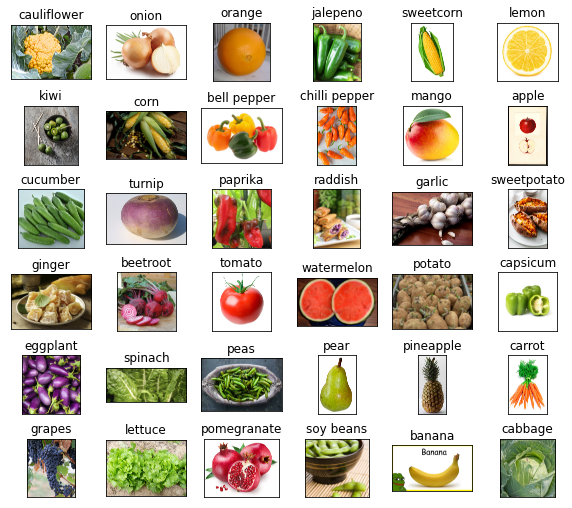

In [20]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [21]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [22]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [23]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [24]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [25]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [26]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
52/87 [================>.............] - ETA: 1:10 - loss: 2.2797 - accuracy: 0.4283

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


87/87 [==============================] - 208s 2s/step - loss: 1.7869 - accuracy: 0.5295 - val_loss: 0.5246 - val_accuracy: 0.8293
Epoch 2/5
87/87 [==============================] - 199s 2s/step - loss: 0.6047 - accuracy: 0.8036 - val_loss: 0.3027 - val_accuracy: 0.9222
Epoch 3/5
87/87 [==============================] - 200s 2s/step - loss: 0.3456 - accuracy: 0.8921 - val_loss: 0.2275 - val_accuracy: 0.9641
Epoch 4/5
87/87 [==============================] - 199s 2s/step - loss: 0.2234 - accuracy: 0.9335 - val_loss: 0.1623 - val_accuracy: 0.9521
Epoch 5/5
87/87 [==============================] - 200s 2s/step - loss: 0.1505 - accuracy: 0.9550 - val_loss: 0.1510 - val_accuracy: 0.9641


In [27]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 34s 2s/step


['beetroot',
 'potato',
 'cabbage',
 'lemon',
 'garlic',
 'bell pepper',
 'watermelon',
 'lemon',
 'capsicum',
 'grapes',
 'garlic',
 'capsicum',
 'jalepeno',
 'banana',
 'eggplant',
 'tomato',
 'bell pepper',
 'bell pepper',
 'lettuce',
 'corn',
 'cabbage',
 'raddish',
 'cauliflower',
 'turnip',
 'paprika',
 'lettuce',
 'peas',
 'kiwi',
 'jalepeno',
 'cucumber',
 'carrot',
 'onion',
 'corn',
 'lettuce',
 'carrot',
 'soy beans',
 'lemon',
 'ginger',
 'corn',
 'ginger',
 'paprika',
 'tomato',
 'capsicum',
 'mango',
 'grapes',
 'mango',
 'potato',
 'sweetcorn',
 'cucumber',
 'onion',
 'watermelon',
 'spinach',
 'capsicum',
 'beetroot',
 'pomegranate',
 'ginger',
 'eggplant',
 'potato',
 'orange',
 'mango',
 'beetroot',
 'jalepeno',
 'corn',
 'chilli pepper',
 'watermelon',
 'pear',
 'cauliflower',
 'pineapple',
 'pear',
 'onion',
 'lettuce',
 'raddish',
 'watermelon',
 'pineapple',
 'mango',
 'peas',
 'turnip',
 'ginger',
 'pomegranate',
 'sweetcorn',
 'cauliflower',
 'soy beans',
 'cucu

In [28]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [29]:
model.save('model.h5')